# Laboratorio 1: Detección de Phishing

## Objetivos

- Realizar una revisión de la literatura para identificar características potenciales en las URLs de phishing.
- Implementar un modelo de *Machine Learning* para clasificar si un dominio es legítimo o phishing.

## Integrantes

- **Javier Prado** — 21486  
- **Bryan España** — 21550

# Parte 1 - Ingenieria de caracteristicas
## Exploracion de datos
1. Cargue el dataset en un dataframe de pandas, muestre un ejemplo de cinco observaciones.

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('dataset_pishing.csv')

In [6]:
df.head()

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


2. Muestre la cantidad de observaciones etiquetadas en la columna status como “legit” y como
“pishing”. ¿Está balanceado el dataset?


In [7]:
df.status.value_counts()

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

In [8]:
df['status'] = df['status'].map({'legitimate': 0, 'phishing': 1})
df.head()

,url,status
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0


El dataset tiene la misma cantidad de url tanto como con estado 'legitimate' y 'pishing' por lo cual este dataset esta balanceado

## Derivación de características
Revise los artículos proporcionados, especialmente en el análisis de las URLs. En base a su análisis
responda las siguientes preguntas:
1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo
de vida del dominio, o las características de la página Web?
- El análisis de URLs presenta varias ventajas significativas frente a otros enfoques utilizados en la detección de phishing, como el análisis del tiempo de vida del dominio o las características del contenido de la página web. Una ventaja es que el análisis de URLs es especialmente eficaz frente a ataques de tipo zero-day, ya que no depende de listas negras ni de información histórica del dominio. Por ejemplo, el tiempo de vida del dominio, aunque es una característica útil, suele requerir acceso a servicios externos como WHOIS, lo que introduce retrasos y dependencia de terceros. Varios estudios destacan que los atacantes suelen ocultar o minimizar el contenido de las páginas phishing, utilizando sitios con muy poca información o contenido dinámico, lo que dificulta los enfoques basados en análisis de páginas web. En estos casos, la URL sigue siendo una fuente de información confiable y accesible para la detección del ataque

2. ¿Qué características de una URL son más prometedoras para la detección de phishing?
Algunas caracteristicas de las URLs para detectar pishing es que la estructura de la URL son especialmente relevantes, dado que se busca la longitud total de la URL, el número de subdominios, la cantidad de '.' y el uso de direcciones IP en lugar de nombres de dominio. Por lo que las URL de pishing suelen ser más largas y complejas con el objetivo de confundir al user. Tambien otra caracteristica es presencias como simbolos @, -, _, // y otros sibolos no alfanumericos son común en URL maliciosas. Tanvuen aun que no se considera estrictamente parte de la URL, las características temporales asociadas al dominio, como la reciente creación del dominio o cambios frecuentes en la configuración, complementan eficazmente el análisis cuando están disponibles.

En base a la respuesta anterior escriba al menos quince funciones basadas en los artículos, para
derivar características que un modelo pueda utilizar y añada dichas características al dataset original.
Incluya dentro de las quince funciones, la entropía de Shanon y relativa.

In [9]:
from urllib.parse import urlparse
from collections import Counter
import math

In [10]:
# Longitud de la URL
def url_length(url):
    return len(url)

In [11]:
# Longitud del dominio
def domain_length(url):
    return len(urlparse(url).netloc)

In [12]:
# Número de subdominios
def count_subdomains(url):
    domain = urlparse(url).netloc
    return domain.count('.')

In [13]:
# Uso de direccion ip en lugar de dominio
def has_ip_address(url):
    domain = urlparse(url).netloc
    return int(any(char.isdigit() for char in domain))

In [14]:
# Cantidad de digitos en la URL
def count_digits(url):
    return sum(char.isdigit() for char in url)  

In [15]:
# Cantidad de letras
def count_letters(url):
    return sum(char.isalpha() for char in url)

In [16]:
# cantidad de caracteres especiales
def count_special_characters(url):
    return sum(not char.isalnum() for char in url)

In [17]:
# presencia del simbolo @
def has_at_symbol(url):
    return int('@' in url)

In [18]:
# Presencua de guioes
def has_hyphen(url):
    return int('-' in url)

In [19]:
# Presencia de doble slash //
def has_double_slash(url):
    return int(url.find('//', url.find('//') + 2) != -1)

In [20]:
# Uso de HTTPS
def uses_https(url):
    return int(urlparse(url).scheme == 'https')

In [21]:
# numero de parametros en la URL
def count_parameters(url):
    return urlparse(url).query.count('&') + 1 if urlparse(url).query else 0

In [22]:
# shannon entropy H(X)=−∑p(x)log2​p(x)) para cada caracter en la URL
def shannon_entropy(url):
    if not url:
        return 0.0

    char_counts = Counter(url)
    total_chars = len(url)

    entropy = 0.0
    for count in char_counts.values():
        p = count / total_chars
        entropy -= p * math.log2(p)

    return entropy

In [23]:
# relative entropy 
def relative_entropy(url):
    if not url:
        return 0.0

    unique_chars = len(set(url))
    if unique_chars <= 1:
        return 0.0

    max_entropy = math.log2(unique_chars)
    return shannon_entropy(url) / max_entropy

In [24]:
# Longitud del path de la URL
def path_length(url):
    return len(urlparse(url).path)

# Preprocesamiento y seleccion de caracteres

In [25]:
# Aplicar las 15 funciones para crear características
df['url_length'] = df['url'].apply(url_length)
df['domain_length'] = df['url'].apply(domain_length)
df['count_subdomains'] = df['url'].apply(count_subdomains)
df['has_ip_address'] = df['url'].apply(has_ip_address)
df['count_digits'] = df['url'].apply(count_digits)
df['count_letters'] = df['url'].apply(count_letters)
df['count_special_chars'] = df['url'].apply(count_special_characters)
df['has_at_symbol'] = df['url'].apply(has_at_symbol)
df['has_hyphen'] = df['url'].apply(has_hyphen)
df['has_double_slash'] = df['url'].apply(has_double_slash)
df['uses_https'] = df['url'].apply(uses_https)
df['count_parameters'] = df['url'].apply(count_parameters)
df['shannon_entropy'] = df['url'].apply(shannon_entropy)
df['relative_entropy'] = df['url'].apply(relative_entropy)
df['path_length'] = df['url'].apply(path_length)

print(f"Dataset con {df.shape[1]} columnas y {df.shape[0]} filas")
df.head()

Dataset con 17 columnas y 11430 filas


,url,status,url_length,domain_length,count_subdomains,has_ip_address,count_digits,count_letters,count_special_chars,has_at_symbol,has_hyphen,has_double_slash,uses_https,count_parameters,shannon_entropy,relative_entropy,path_length
0,http://www.crestonwood.com/router.php,0,37,19,2,0,0,30,7,0,0,0,0,0,3.787043,0.946761,11
1,http://shadetreetechnology.com/V4/validation/a...,1,77,23,1,0,17,53,7,0,0,0,0,0,4.419864,0.909815,47
2,https://support-appleld.com.secureupdate.duila...,1,126,50,4,0,19,88,19,0,1,0,1,3,4.753412,0.942316,20
3,http://rgipt.ac.in,0,18,11,2,0,0,13,5,0,0,0,0,0,3.461320,0.965511,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,55,15,2,0,0,45,10,0,1,0,0,0,4.097662,0.948110,33


## 1. Verificar observaciones duplicadas

In [26]:
# Verificar y eliminar duplicados
print(f"Observaciones duplicadas encontradas: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Observaciones después de eliminar duplicados: {len(df)}")

Observaciones duplicadas encontradas: 1
Observaciones después de eliminar duplicados: 11429


## 2. Identificar columnas constantes y de baja varianza

In [27]:
import numpy as np

# Seleccionar solo columnas numéricas (excluir 'url')
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calcular varianza de cada columna
variance = df[numeric_cols].var()
print("Varianza de cada característica:")
print(variance.sort_values())

# Identificar columnas constantes (varianza = 0)
constant_cols = variance[variance == 0].index.tolist()
print(f"\nColumnas constantes (varianza = 0): {constant_cols if constant_cols else 'Ninguna'}")

# Identificar columnas con baja varianza (umbral < 0.01)
low_variance_cols = variance[(variance > 0) & (variance < 0.01)].index.tolist()
print(f"Columnas con baja varianza (< 0.01): {low_variance_cols if low_variance_cols else 'Ninguna'}")

Varianza de cada característica:
relative_entropy          0.000280
has_double_slash          0.006520
has_at_symbol             0.020979
has_ip_address            0.115510
shannon_entropy           0.170826
uses_https                0.237722
has_hyphen                0.238448
status                    0.250022
count_subdomains          0.741224
count_parameters          1.050491
count_special_chars      36.815661
domain_length           116.180459
count_digits            266.362374
path_length             769.467745
count_letters          1506.353764
url_length             3057.520355
dtype: float64

Columnas constantes (varianza = 0): Ninguna
Columnas con baja varianza (< 0.01): ['has_double_slash', 'relative_entropy']


## 3. Análisis de correlación con la variable objetivo (status)

In [28]:
# Correlación de cada característica con la variable objetivo
correlation_with_status = df[numeric_cols].corr()['status'].drop('status').sort_values(key=abs, ascending=False)
print("Correlación de cada característica con 'status':")
print(correlation_with_status)

# Identificar características con muy baja correlación (|r| < 0.05)
low_corr_features = correlation_with_status[abs(correlation_with_status) < 0.05].index.tolist()
print(f"\nCaracterísticas con baja correlación con status (|r| < 0.05): {low_corr_features if low_corr_features else 'Ninguna'}")

Correlación de cada característica con 'status':
shannon_entropy        0.336581
has_ip_address         0.280917
url_length             0.248504
count_digits           0.240443
domain_length          0.238489
count_parameters       0.230614
count_letters          0.221805
count_special_chars    0.199124
relative_entropy      -0.163215
has_at_symbol          0.148021
uses_https            -0.114607
path_length            0.107635
count_subdomains       0.102452
has_double_slash       0.072613
has_hyphen             0.065475
Name: status, dtype: float64

Características con baja correlación con status (|r| < 0.05): Ninguna


## 4. Visualización de correlaciones (Heatmap)

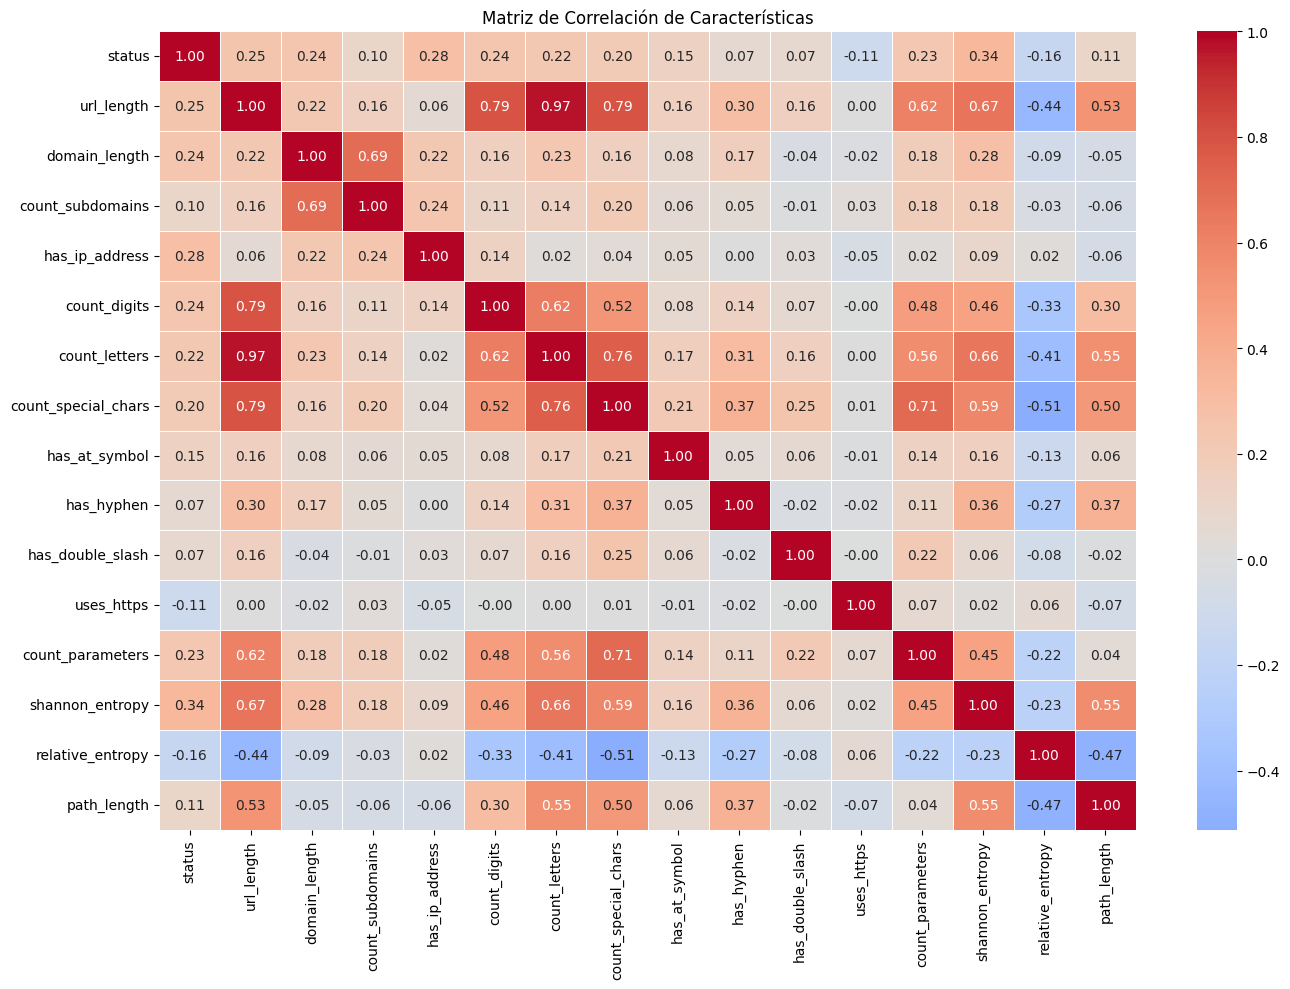

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de correlación
plt.figure(figsize=(14, 10))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Características')
plt.tight_layout()
plt.show()

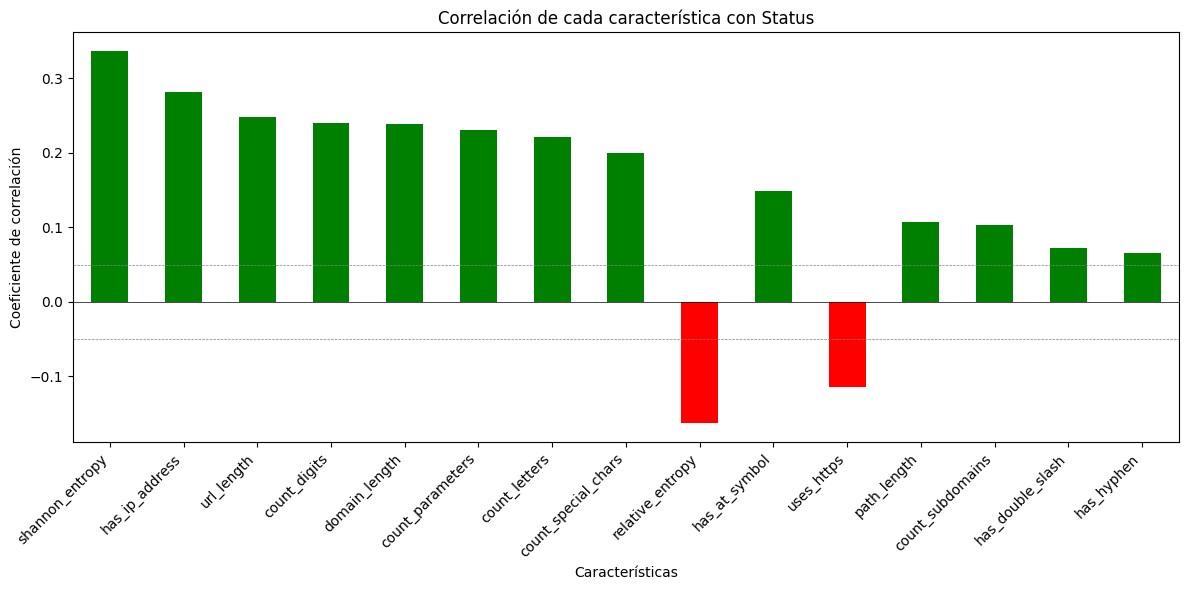

In [30]:
# Gráfico de barras de correlación con status
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in correlation_with_status.values]
correlation_with_status.plot(kind='bar', color=colors)
plt.title('Correlación de cada característica con Status')
plt.xlabel('Características')
plt.ylabel('Coeficiente de correlación')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=0.05, color='gray', linestyle='--', linewidth=0.5, label='Umbral ±0.05')
plt.axhline(y=-0.05, color='gray', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Identificar características altamente correlacionadas entre sí (redundantes)

In [31]:
# Encontrar pares de características con alta correlación (|r| > 0.9)
high_corr_threshold = 0.9
high_corr_pairs = []

feature_cols = [col for col in numeric_cols if col != 'status']
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        corr_val = abs(correlation_matrix.loc[feature_cols[i], feature_cols[j]])
        if corr_val > high_corr_threshold:
            high_corr_pairs.append((feature_cols[i], feature_cols[j], corr_val))

print(f"Pares de características con correlación > {high_corr_threshold}:")
for pair in high_corr_pairs:
    print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")

Pares de características con correlación > 0.9:
  url_length - count_letters: 0.969


## 6. Selección final de características

Se eliminarán:
- Columnas constantes o con varianza muy baja
- Características con muy baja correlación con status (irrelevantes)
- Una de cada par de características altamente correlacionadas (redundantes)

In [32]:
# Características a eliminar
features_to_remove = set()

# Agregar columnas constantes
features_to_remove.update(constant_cols)

# Agregar columnas con baja varianza
features_to_remove.update(low_variance_cols)

# Agregar características con muy baja correlación con status
features_to_remove.update(low_corr_features)

# Para características altamente correlacionadas, eliminar la que tenga menor correlación con status
for pair in high_corr_pairs:
    corr1 = abs(correlation_with_status.get(pair[0], 0))
    corr2 = abs(correlation_with_status.get(pair[1], 0))
    # Eliminar la característica con menor correlación con status
    if corr1 < corr2:
        features_to_remove.add(pair[0])
    else:
        features_to_remove.add(pair[1])

print(f"Características a eliminar: {features_to_remove if features_to_remove else 'Ninguna'}")

# Crear dataset final
df_final = df.drop(columns=['url'] + list(features_to_remove), errors='ignore')
print(f"\nDataset final: {df_final.shape[1]} características, {df_final.shape[0]} observaciones")
print(f"Características seleccionadas: {df_final.columns.tolist()}")

Características a eliminar: {'has_double_slash', 'relative_entropy', 'count_letters'}

Dataset final: 13 características, 11429 observaciones
Características seleccionadas: ['status', 'url_length', 'domain_length', 'count_subdomains', 'has_ip_address', 'count_digits', 'count_special_chars', 'has_at_symbol', 'has_hyphen', 'uses_https', 'count_parameters', 'shannon_entropy', 'path_length']


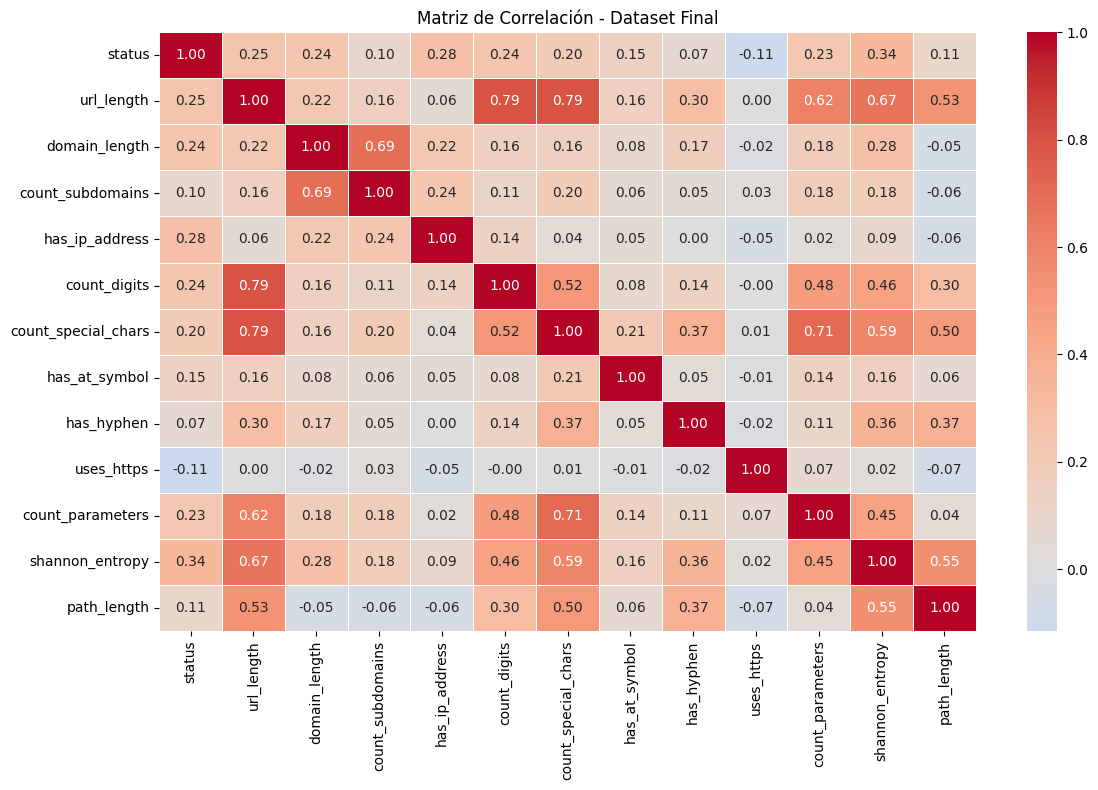

,status,url_length,domain_length,count_subdomains,has_ip_address,count_digits,count_special_chars,has_at_symbol,has_hyphen,uses_https,count_parameters,shannon_entropy,path_length
count,11429.000000,11429.000000,11429.000000,11429.000000,11429.000000,11429.000000,11429.000000,11429.000000,11429.000000,11429.000000,11429.000000,11429.000000,11429.000000
mean,0.499956,61.120658,21.099746,2.052323,0.133258,5.452271,9.972526,0.021437,0.392423,0.389098,0.291627,4.233350,23.146295
std,0.500022,55.294849,10.778704,0.860944,0.339868,16.320612,6.067591,0.144841,0.488311,0.487567,1.024935,0.413312,27.739282
min,0.000000,12.000000,4.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,2.952820,0.000000
25%,0.000000,33.000000,15.000000,2.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,3.967586,1.000000
50%,0.000000,47.000000,19.000000,2.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,4.188331,17.000000
75%,1.000000,71.000000,24.000000,2.000000,0.000000,5.000000,12.000000,0.000000,1.000000,1.000000,0.000000,4.453189,33.000000
max,1.000000,1641.000000,214.000000,14.000000,1.000000,679.000000,113.000000,1.000000,1.000000,1.000000,20.000000,5.996952,602.000000


In [33]:
# Visualización final - Heatmap del dataset procesado
plt.figure(figsize=(12, 8))
final_corr = df_final.corr()
sns.heatmap(final_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación - Dataset Final')
plt.tight_layout()
plt.show()

# Resumen estadístico del dataset final
df_final.describe()

Las columnas constantes presentan el mismo valor en todas las observaciones, por lo que no aportan información discriminativa al modelo. Por otro lado, las columnas con baja varianza ('has_double_slash', 'relative_entropy') muestran muy poca variabilidad entre observaciones, lo que limita su capacidad para diferenciar entre sitios legítimos y de phishing. Por esta razón, dichas características fueron eliminadas durante la etapa de selección de características.


### ¿Qué columnas o características fueron seleccionadas y por qué?
- Tras la etapa de preprocesamiento y selección de características, se seleccionó un conjunto de variables que aportan información relevante para la clasificación de sitios web como legítimos o de phishing, evitando redundancia y características poco informativas.

En primer lugar, se eliminaron las características has_double_slash y relative_entropy, ya que presentaban una varianza muy baja, lo que indica que sus valores cambian muy poco entre observaciones y, por tanto, aportan escasa capacidad discriminativa. Asimismo, se eliminó la característica count_letters, debido a su alta correlación con url_length (≈ 0.97), lo que la hace redundante y potencialmente problemática por multicolinealidad.

Posteriormente, se conservaron las características que mostraron una correlación significativa o moderada con la variable objetivo (status), así como aquellas que, aun teniendo una correlación individual menor, aportan información complementaria relevante desde el punto de vista semántico y estructural de la URL

Características seleccionadas:

shannon_entropy: presenta la mayor correlación con la variable objetivo, capturando el grado de aleatoriedad de la URL, el cual suele ser mayor en URLs de phishing.

has_ip_address: indica si la URL utiliza una dirección IP en lugar de un nombre de dominio, un patrón común en sitios de phishing.

url_length y domain_length: reflejan la longitud y complejidad de la URL y del dominio, características asociadas frecuentemente a URLs maliciosas.

count_digits y count_special_chars: capturan la presencia de dígitos y caracteres especiales, que suelen aparecer en mayor proporción en URLs de phishing.

count_parameters y path_length: describen la complejidad de la estructura de la URL y el uso de parámetros, comunes en intentos de ocultar la verdadera intención del enlace.

count_subdomains: permite identificar URLs con múltiples subdominios, una técnica utilizada para imitar sitios legítimos.

has_at_symbol y has_hyphen: aunque presentan una correlación menor, aportan información léxica complementaria útil en combinación con otras características.

uses_https: se mantuvo a pesar de su correlación negativa moderada, ya que refleja el uso de certificados SSL, un comportamiento presente tanto en sitios legítimos como en sitios de phishing modernos, y puede aportar valor en modelos no lineales.

# Parte 2 - implementacion
## Separacion de datos 
- Datos de entrenamiento 55%
- datos de validacion: 30%
- datos de prueba: 30%

In [34]:
from sklearn.model_selection import train_test_split

# Separar características (X) y variable objetivo (y)
X = df_final.drop(columns=['status'])
y = df_final['status']

# Primera división: 70% temporal (55% train + 15% val) y 30% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Segunda división: del 70% temporal -> 55/70 ≈ 78.57% train y 15/70 ≈ 21.43% validación
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2143, random_state=42, stratify=y_temp)

# Crear DataFrames completos para guardar
train_df = X_train.copy()
train_df['status'] = y_train

val_df = X_val.copy()
val_df['status'] = y_val

test_df = X_test.copy()
test_df['status'] = y_test

# Verificar proporciones
total = len(df_final)
print(f"Dataset original: {total} observaciones")
print(f"Entrenamiento: {len(train_df)} ({len(train_df)/total*100:.1f}%)")
print(f"Validación: {len(val_df)} ({len(val_df)/total*100:.1f}%)")
print(f"Prueba: {len(test_df)} ({len(test_df)/total*100:.1f}%)")

Dataset original: 11429 observaciones
Entrenamiento: 6285 (55.0%)
Validación: 1715 (15.0%)
Prueba: 3429 (30.0%)


In [35]:
# Guardar los datasets en archivos CSV
train_df.to_csv('train_pishing.csv', index=False)
val_df.to_csv('val_pishing.csv', index=False)
test_df.to_csv('test_pishing.csv', index=False)

print("Archivos guardados exitosamente:")
print("  - train_pishing.csv")
print("  - val_pishing.csv")
print("  - test_pishing.csv")

Archivos guardados exitosamente:
  - train_pishing.csv
  - val_pishing.csv
  - test_pishing.csv
